# VQE FOR FINDING THE LOWEST EIGEN VALUE

#### __Problem statement for task 4__ -
 
Find the lowest eigenvalue of the following matrix:

$$\begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & -1 & 0\\ 0 & -1 & 0 & 0\\ 0 & 0 & 0 & 1 \end{pmatrix}$$

using VQE-like circuits, created by yourself from scratch.

#### **Software used** - Used **Qiskit(0.19.6)**

First I'll try to simulate VQE without any noise than in the later part I'll try to run it with noise

##  **VQE SIMULATED WITHOUT ANY NOISE**

### Finding out the lowest eigenvalue by first finding out all the eigenvalues

In [1]:
%matplotlib inline
import numpy as np
from numpy import pi, linspace
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from scipy import optimize
from qiskit.test.mock import FakeTokyo
import qiskit.tools.jupyter
from qiskit.providers.aer.noise import NoiseModel

In [2]:
# The given Hamiltonian matrix
H = np.mat("1 0 0 0; 0 0 -1 0; 0 -1 0 0; 0 0 0 1")
# Printing out the eigenvalues and lowest one of them
print("The eigenvalues of the Hamiltonian is: ", np.linalg.eigvals(H))
print('The exact ground state energy is: ', min(np.linalg.eigvals(H)))

The eigenvalues of the Hamiltonian is:  [ 1. -1.  1.  1.]
The exact ground state energy is:  -1.0


#### Now we know that the lowest eigenvalue is -1.0

### Before we do that, we need to express the given Hamiltonian matrix in a quantum circuit. Doing this will enable Quantum Computer to measure the expectation values.    This will be done by decomposing the hamiltonian in terms of the linear combination of the tensor products of Pauli operators i.e.
$$H = \alpha*I \otimes I + \beta*X \otimes X + \gamma*Y \otimes Y + \theta*Z \otimes Z $$  

#### Finally we have to solve the the equation Ax = b, to find the values of 
$\alpha , \beta, \gamma$ and $\theta$ <br/><br/>
Here matrices A, x and b are $\begin{pmatrix} 1 & 0 & 1 & 0\\ 0 & 1 & 0 & -1\\ 1 & 0 & -1 & 0\\ 0 & 1 & 0 & 1 \end{pmatrix}$ ,$ \begin{pmatrix} \alpha\\ \beta\\ \theta\\ \gamma\end{pmatrix}$ and $\begin{pmatrix} 1 \\ 0 \\ 0 \\ -1 \end{pmatrix}$ respectively.

In [3]:
A = np.array([[1,0,1,0],[0,1,0,-1],[1,0,-1,0],[0,1,0,1]])
b = np.array([1,0,0,-1])
x = np.linalg.solve(A,b)
alpha, beta, gamma, theta = x[0], x[1], x[3], x[2]
print(f"Therefore the Hamiltonian H = {alpha}*II + {beta}*XX + {gamma}*YY + {theta}*ZZ ")

Therefore the Hamiltonian H = 0.5*II + -0.5*XX + -0.5*YY + 0.5*ZZ 


### Applying Variational method to get the minimum energy which would be our eigen value that has the lowest eigen value.

In [4]:
def ansatz(circuit, parameter):
    qreg = circuit.qregs[0]
    circuit.h(qreg[0])
    circuit.rz(parameter, qreg[0])
    circuit.cx(qreg[0], qreg[1])
    circuit.x(qreg[1])
    return circuit

### Now we want to measure them therefore there is a need to convert them into a computational basis(Z basis). 
We know that X basis  ($\lvert + \rangle$,  $\lvert-\rangle$) can be measured into Z basis by applying the Hadamard gate and
Similarly Y basis ($\lvert \circlearrowleft \rangle$, $\lvert \circlearrowright \rangle$) can be measured into Z basis by first applying S-dagger gate and then Hadamard gate.<br/> Here therefore the two gates are to be applied for X and Y bases are: <br/><br/>
$\tfrac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$  <br/><br/>and<br/><br/> $ \tfrac{1}{\sqrt{2}} \begin{pmatrix}1 & -i\\1 & -i\end{pmatrix}$  , respectively

In [5]:
# So we'll create a function which will help us to measure in all three basis 
def measurement(measured, parameter):
    # Applying ansatz for the circuit
    qreg = QuantumRegister(2)
    creg = ClassicalRegister(2)
    circuit = QuantumCircuit(qreg, creg)
    circuit = ansatz(circuit, parameter)
    
    # Now checking different bases and if they're not computational basis then applying necessary gates.
    # Just measuring it if it's ZZ     
    if measured == 'ZZ':
        circuit.measure(qreg[0], creg[0])
        circuit.measure(qreg[1], creg[1]) 
    elif measured == 'XX':
        circuit.barrier(qreg[0],qreg[1])
        circuit.u2(0, pi, qreg[0])
        circuit.u2(0, pi, qreg[1])
        circuit.measure(qreg[0], creg[0])
        circuit.measure(qreg[1], creg[1])
    elif measured == 'YY':
        circuit.barrier(qreg[0],qreg[1])
        circuit.u2(0, pi/2, qreg[0])
        circuit.u2(0, pi/2, qreg[1])
        circuit.measure(qreg[0], creg[0])
        circuit.measure(qreg[1], creg[1])
    return circuit

### We know that the expectation value can be calculated in the Z basis through:
$$ \tfrac{1}{N}(N_{00} + N_{11} - N_{01} - N_{10}) $$
Here the $N_{01}, N_{10}$ are multiplied with -1 but $N_{00}, N_{11}$ are multiplied with 1 as <br/><br/>
$\langle 01|Z \otimes Z|01 \rangle = \langle 10|Z \otimes Z|10 \rangle = -1$ <br/><br/>
 and <br/><br/>
$ \langle 00|Z \otimes Z|00 \rangle = \langle 11|Z \otimes Z|11 \rangle = 1$

In [6]:
# Now we need to calculate the expectation values
def exp_value(measured, parameter, noise_model, basis_gates, coupling_map):
    if measured == 'II':
        return 1
    if measured == 'XX':
        circuit = measurement('XX', parameter)
    elif measured == 'YY':
        circuit = measurement('YY', parameter)
    elif measured == 'ZZ':
        circuit = measurement('ZZ', parameter)
    
    backend = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = backend, noise_model=noise_model,
                    basis_gates=basis_gates, coupling_map=coupling_map).result()
    counts = result.get_counts()
    # When counts of 00, 11, 01 or 10 are zero so we need to tackle that exception
    counts_00, counts_01, counts_10, counts_11 = [0]*4
    for x in counts:
        if x == '00':
            counts_00 = counts[x]
        if x == '01':
            counts_01 = counts[x]
        if x == '10':
            counts_10 = counts[x]
        if x == '11':
            counts_11 = counts[x]
            
    expec_value = (counts_00 + counts_11 - counts_01 - counts_10)/1024
        
    return expec_value

In [7]:
# Calculating sum of products of coefficients and their respective expectation values to calculate 
# summation of expectation value  
def summation(parameter):
    # I will give more info about this in the summation_noise section because explaining it here seems irrelevant.
    # Running on a simulator that doesn't have any noise
    device_backend = FakeTokyo()
    # Here taking no noise
    noise_model = NoiseModel()
    # For transpilling to correct gates before simulation, device coupling maps are needed
    coupling_map = device_backend.configuration().coupling_map
    # Basis gate would also be required
    basis_gates = noise_model.basis_gates
    exp_value_I_I = exp_value('II', parameter, noise_model, basis_gates, coupling_map) * alpha
    exp_value_X_X = exp_value('XX', parameter, noise_model, basis_gates, coupling_map) * beta
    exp_value_Y_Y = exp_value('YY', parameter, noise_model, basis_gates, coupling_map) * gamma
    exp_value_Z_Z = exp_value('ZZ', parameter, noise_model, basis_gates, coupling_map) * theta
    
    sum_exp = exp_value_I_I + exp_value_X_X + exp_value_Y_Y + exp_value_Z_Z
    return sum_exp

In [8]:
    # applying minimize function with method as cobyla and tolerance equal to 1e-4
    parameter = 0
    sum_result = optimize.minimize(summation, parameter, method="COBYLA", tol=1e-4)
    # printing the lowest evalue which we found before
    print('The exact ground state energy is: -1')
    print(f'The estimated ground state energy from VQE algorithm is: {sum_result.fun}')
    # finding the best parameter which minimizes the expectation value
    print(f"\nThe optimal parameter is : {sum_result.x} ")
    # List of parameters ranging from -pi to pi
    gradients = np.linspace(-pi, pi, 50)
    minimal = []
    # Iterating over parameters to get their respective expectation value
    for parameter in gradients:
        minimal_value = summation(parameter)
        minimal.append(minimal_value) 

The exact ground state energy is: -1
The estimated ground state energy from VQE algorithm is: -1.0

The optimal parameter is : 0.0 


In [9]:
 def graph_plotter(title, text=-0.8, pos=-1, minimal=None,minimal_noise=None):
    # Plotting a graph to visualize expectation values and parameters.   
    figure = plt.figure(figsize=(20,15))
    axes = figure.add_subplot()
    if minimal != None:
        axes.plot(gradients, minimal, linewidth=2.5, color='blue', label="Noiseless")
    if minimal_noise != None:    
        axes.plot(gradients, minimal_noise, linewidth=2.5, color='red', label="With Noise")
    # The best parameter is 0 which one would expect
    if isinstance(text, float):
        axes.annotate('Lowest Eigenvalue', xytext=(0, text), xy=(0, pos),
                 arrowprops=dict(facecolor='red'))
    elif len(text) == 2:
        axes.annotate('Noise ', xytext=(0, text[0]), xy=(0, pos[0]),
                 arrowprops=dict(facecolor='red'))
        axes.annotate('Noiseless ', xytext=(0, text[1]), xy=(0, pos[1]),
                 arrowprops=dict(facecolor='green'))
    axes.xaxis.set_minor_locator(AutoMinorLocator()) 
    axes.xaxis.set_minor_formatter(FuncFormatter(FormatStrFormatter('%.1f'))) 
    # Showing legend in general which would be helpful when we compare graphs
    axes.legend(prop={'size': 18})
    # Controlling the minor, major graduation and then graduation for both axes
    axes.tick_params(which='minor', length=3, color='black')
    axes.tick_params(which='major', length=5) 
    axes.tick_params(which='both', width=2) 
    axes.tick_params(labelcolor='black', labelsize=15, width=3.5)
    plt.ylabel(r'$Expectation \; values$', {'fontsize': 21, 'color': 'y'})
    plt.xlabel(r'$The\; parameter\; ranges\; from\; [-\pi,\pi)$',  {'fontsize': 21, 'color': 'y'})
    plt.title(title, {'color': 'y', 'fontsize': 45})
    plt.grid()
    plt.show()

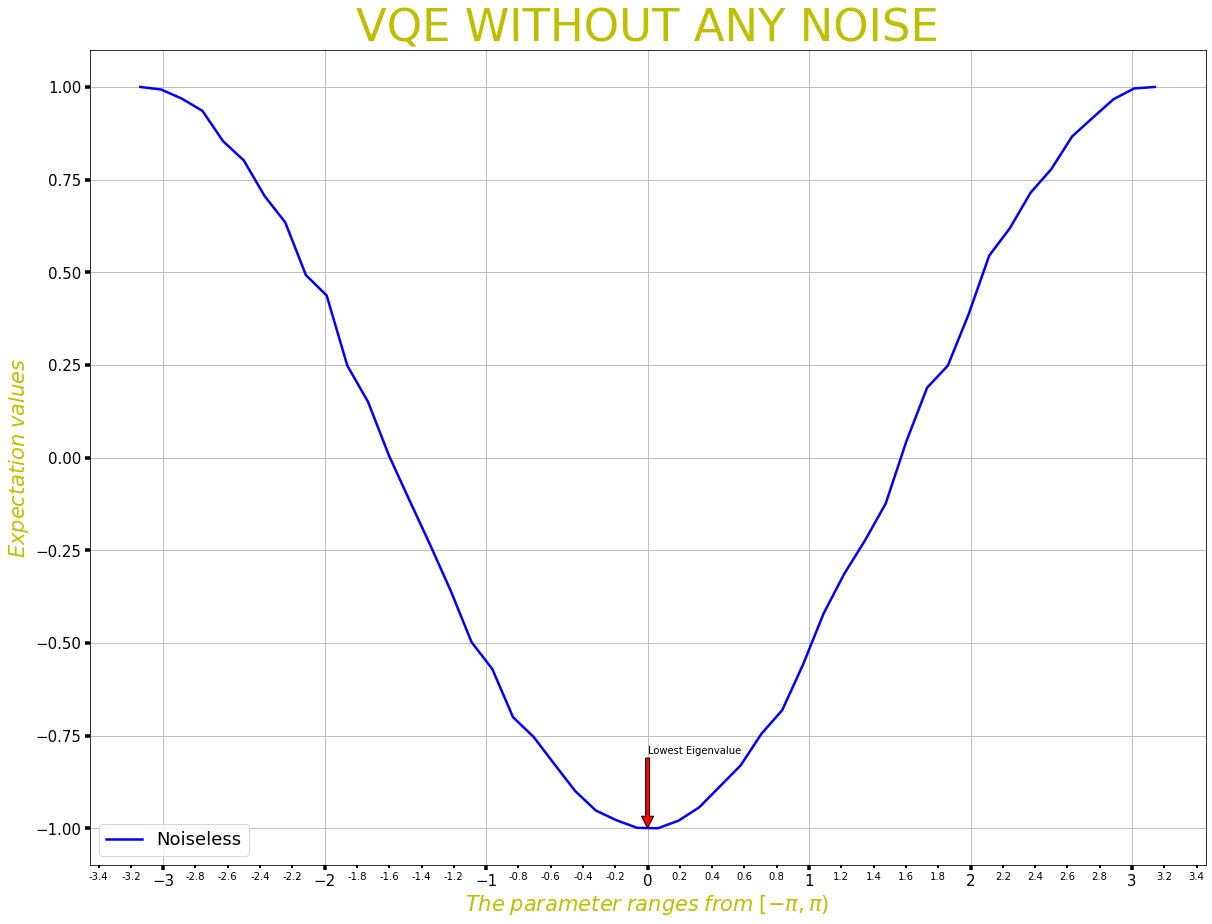

In [10]:
# Plotting the graph for VQE without any noise
graph_plotter("VQE WITHOUT ANY NOISE", minimal=minimal)

In [11]:
# The best angle which given by the optimizer would be utilized through interpolation.
interpol = np.interp(sum_result.x, gradients, minimal)
print("The Lowest Eigenvalue obtained for VQE without noise is: ", interpol)

The Lowest Eigenvalue obtained for VQE without noise is:  -0.99951171875


#### We have obtained the lowest eigenvalue to be &asymp; -0.9995 which is very close to the expected eigenvalue = -1.0. Now it'd be interesting to see how VQE behaves with Noise, so let's see what happens

##  **VQE SIMULATED WITH NOISE**

### Generating a backend noise model
Noise models in Qiskit are presented using the NoiseModel object. It's class has a from_backend method which will return an approximate NoiseModel object configured from a devices BackendProperties. The NoiseModel.from_backend method constructs an approximate noise model consists of single qubit gate errors, two qubit gate errors and single qubit readout errors. 

Here noise_model passes the noise model for creating noisy simulation. We must pass these basis gates to the Qiskit compiler so that it compiles the circuit to the correct gates for the noise model. Lasly we provide the coupling_map so that the compiler will produce a Qobj for the simulator that will match the compiled experiment that  it can be executed on the real device.

In [12]:
# Construct the noise model from backend properties
provider = IBMQ.load_account()
device_backend = provider.get_backend('ibmq_essex')
noise_model = NoiseModel.from_backend(device_backend)
# For transpilling to correct gates before simulation, device coupling maps are needed
coupling_map = device_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates
# Printing out the noise_model to get more understanding about it
print(noise_model)
# And through the Jupyter tools, we will take a closer look at it's properties.
%matplotlib inline
device_backend

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'id', 'cx', 'u2', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


<IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>

#### At the time of running the project, the table below shows the qubit properties which will be used in the noise model
![download](https://user-images.githubusercontent.com/56473003/92989059-c1db7400-f4ee-11ea-9fd2-ed09c04431e1.png)

In [13]:
# creating a similar function to summation but this includes the simulator which has noise
def summation_noise(parameter):
    noise_model = NoiseModel.from_backend(device_backend)
    # Again for transpilling to correct gates before simulation, device coupling maps are needed
    coupling_map = device_backend.configuration().coupling_map
    basis_gates = noise_model.basis_gates
    exp_value_I_I = exp_value('II', parameter, noise_model, basis_gates, coupling_map) * alpha
    exp_value_X_X = exp_value('XX', parameter, noise_model, basis_gates, coupling_map) * beta
    exp_value_Y_Y = exp_value('YY', parameter, noise_model, basis_gates, coupling_map) * gamma
    exp_value_Z_Z = exp_value('ZZ', parameter, noise_model, basis_gates, coupling_map) * theta
    
    sum_exp = exp_value_I_I + exp_value_X_X + exp_value_Y_Y + exp_value_Z_Z
    return sum_exp

In [14]:
# Now again trying to know what would be the optimum parameter but on a simulator with noise 
parameter = 0
# applying minimize function with method as cobyla and tolerance equal to 1e-4
sum_result = optimize.minimize(summation_noise, parameter, method="COBYLA", tol=1e-4)
# printing the lowest evalue which we found before
print('The exact ground state energy is: -1')
print(f'The estimated ground state energy from VQE algorithm is: {sum_result.fun}')
# finding the best parameter which minimiezes the expectation value
print(f"\nThe optimal parameter is : {sum_result.x} ")
# List of parameters ranging from -pi to pi
gradients = np.linspace(-pi, pi, 50)
minimal_noise = []
# Iterating over parameters to get their respective expectation value but now with noise.
for parameter in gradients:
    minimal_value = summation_noise(parameter)
    minimal_noise.append(minimal_value) 

The exact ground state energy is: -1
The estimated ground state energy from VQE algorithm is: -0.7783203125

The optimal parameter is : -0.03525625 


#### The optimal paramter obtained is somewhat different than the one obtained without noise. Which differs slightly from 0

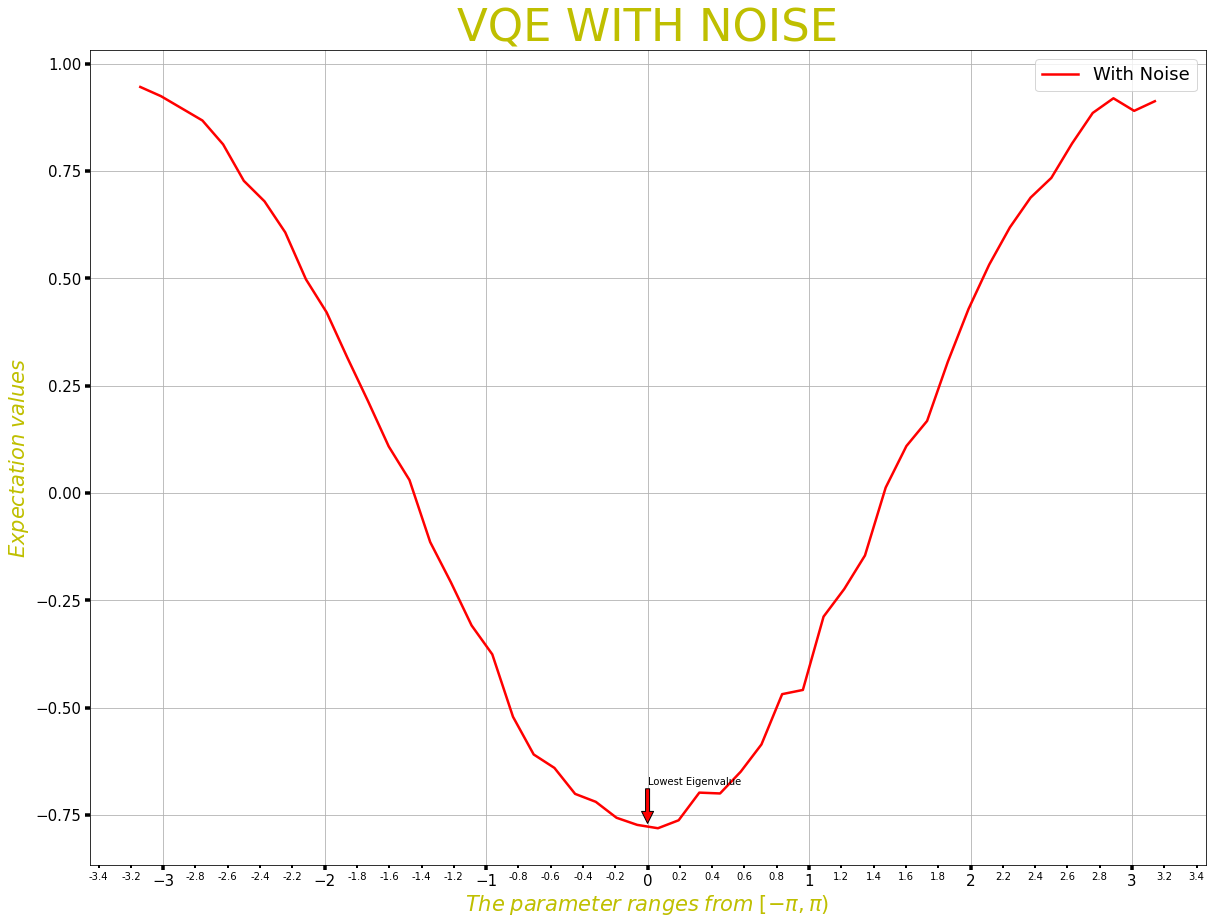

In [15]:
# Plotting the graph for VQE with noise
graph_plotter("VQE WITH NOISE", text=-0.68,pos=-0.77, minimal_noise=minimal_noise)

In [16]:
# Again the best angle which given by the optimizer would be utilized through interpolation.
interpol = np.interp(sum_result.x, gradients, minimal_noise)
print("The Lowest Eigenvalue obtained for VQE with noise is: ", interpol)

The Lowest Eigenvalue obtained for VQE with noise is:  -0.7751957100261188


### Here we see an interesting result that due to noise, the Lowest Eigenvalue obtain is &asymp; -0.7751 which is not as close to one obtained without noise(&asymp; -0.9995).

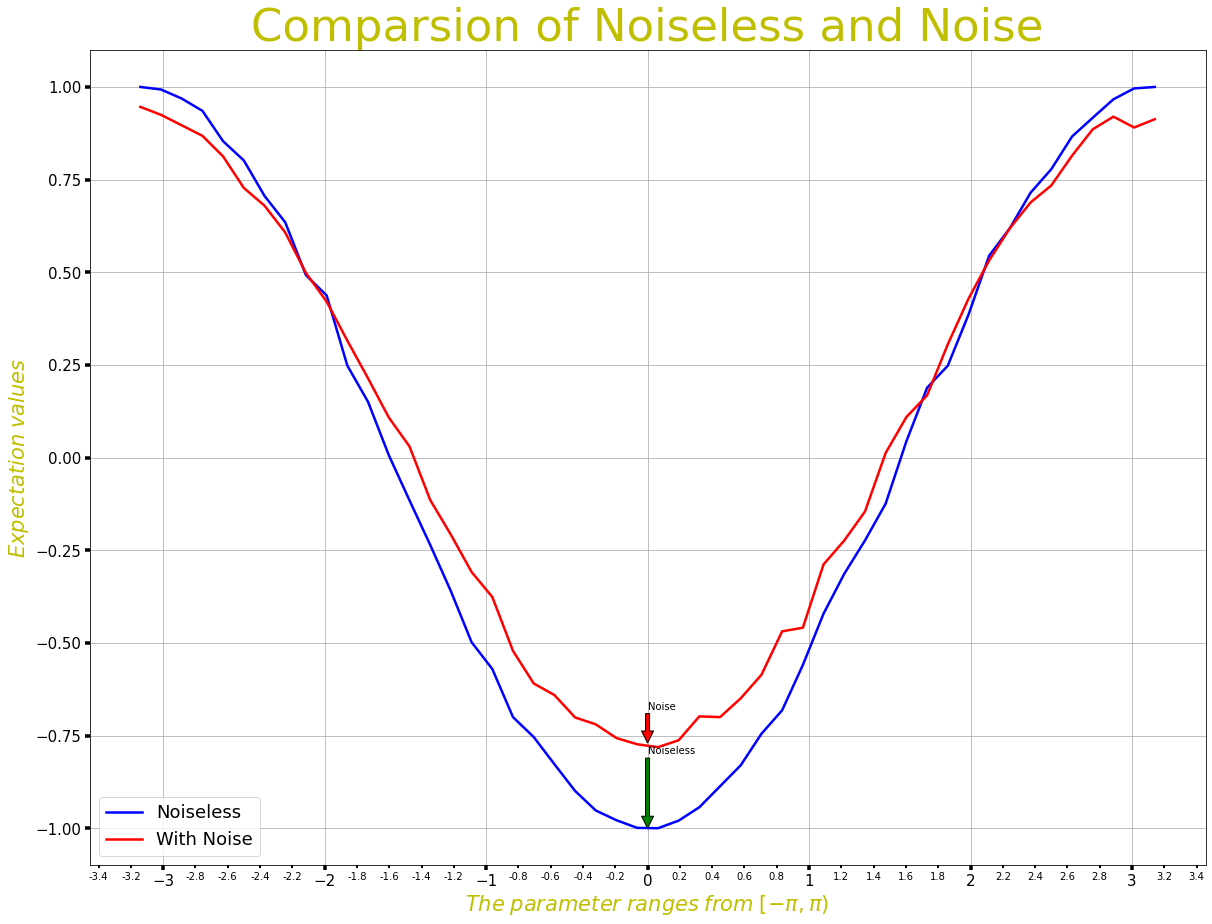

In [17]:
# Trying to visualize the difference between two
graph_plotter("Comparsion of Noiseless and Noise", text=[-0.68,-0.8],pos=[-0.77,-1],minimal=minimal,
              minimal_noise=minimal_noise)

### Now comparing the two graphs it can be easily noticed that the graph plotted with noise isn't as accurate as the one plotted without noise. Thus doing this, we get an intuitive feeling about the effect of noise on the circuit.